In [1]:
import xarray as xr
import numpy as np
import tqdm as tq
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps

from cartopy.io.shapereader import Reader
from toolbar.filter import MovingAverageFilter
from toolbar.masked import masked  # 气象工具函数
from toolbar.K_Mean import K_Mean, plot_test
from toolbar.average_filter import nanmean_filter

# 数据读取
data_year = ['1961', '2022']
# 读取CN05.1逐日最高气温数据
#CN051_1 = xr.open_dataset(r"E:\data\CN05.1\1961_2021\CN05.1_Tmax_1961_2021_daily_025x025.nc")
CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
#CN051 = xr.concat([CN051_1, CN051_2], dim='time')
try:
    Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
except:
    Tmax = xr.concat([CN051_1, CN051_2], dim='time')
    Tmax = masked(Tmax, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域温度
    Tmax = Tmax.sel(time=Tmax['time.month'].isin([6, 7, 8])).groupby('time.year')  # 截取夏季数据
    Tmax_5Day_filt = np.array([[[MovingAverageFilter(iyear[1]['tmax'].data[:, i, j], 'lowpass', [5], np.nan).filted()
                                 for j in range(283)] for i in range(163)] for iyear in tq.tqdm(Tmax)])  # 5天滑动平均
    Tmax_5Day_filt = Tmax_5Day_filt.transpose(0, 3, 1, 2)  # 转换为(year, day, lat, lon)格式
    Tmax_5Day_filt = xr.DataArray(Tmax_5Day_filt,
                                  coords=[[str(i) for i in range(eval(data_year[0]), eval(data_year[1]) + 1)],
                                          [str(i) for i in range(1, 88 + 1)],
                                          CN051_2['lat'].data,
                                          CN051_2['lon'].data],
                                  dims=['year', 'day', 'lat', 'lon'], )
    Tmax_5Day_filt.to_netcdf(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
    del Tmax

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [279]:
T_th = 0.90
t95 = masked(Tmax_5Day_filt, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").mean(dim=['year', 'day']).quantile(T_th)  # 夏季内 长江中下游流域 分位数

In [268]:
t95

<xarray.DataArray ()>
array(31.76166257)
Coordinates:
    quantile  float64 0.9

In [274]:
Tmax_5Day_filt_averTh = nanmean_filter(t95, 11)  # 11*11格点 空间滑动平均
EHD = Tmax_5Day_filt - t95
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
zone_stations = masked((CN051_2 - CN051_2 + 1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
S_q = 0.9
S_th = EHDstations_zone.quantile(S_q).data
S_th = 0.25
EHD20 = EHD.where(EHDstations_zone >= S_th, np.nan)  # 提取极端高温日占比大于10%
# 获取EHD20的年份和日
EHD20_time = np.zeros((EHD20['year'].size, EHD20['day'].size))
for iyear in range(EHD20['year'].size):
    for iday in range(EHD20['day'].size):
        EHD20_time[iyear, iday] = f"{iyear + 1961}{iday:02d}"

In [270]:
EHDstations_zone.quantile(S_th).data

array(0.24697275)

In [275]:
bridge = []
EHD20_time = np.where(EHDstations_zone >= S_th, EHD20_time, np.nan)  # 提取极端高温日占比大于10%
for i in EHD20_time:
    for j in i:
        if not np.isnan(j):
            bridge.append(j)
EHD20_time = np.array(bridge)
EHD20 = masked(EHD20, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 减去非研究地区
EHD20 = EHD20.data.reshape(-1, 163 * 283)
EHD20 = pd.DataFrame(EHD20).dropna(axis=0, how='all')
EHD20_ = EHD20.dropna(axis=1, how='all')

In [276]:
EHD20_time.shape

(2710,)

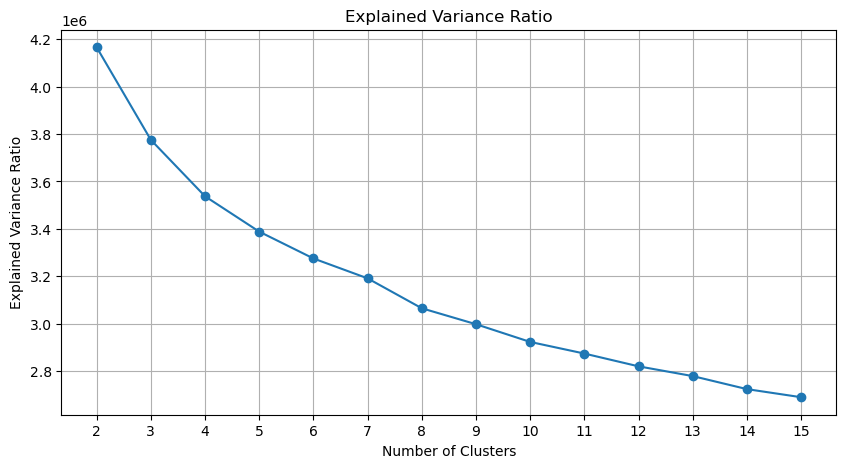

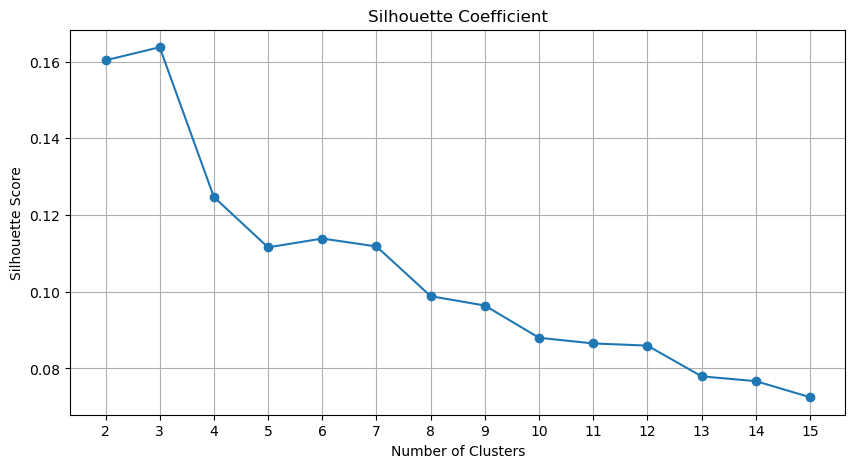

In [277]:
plot_test(EHD20_.to_numpy(), max_clusters=15)

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


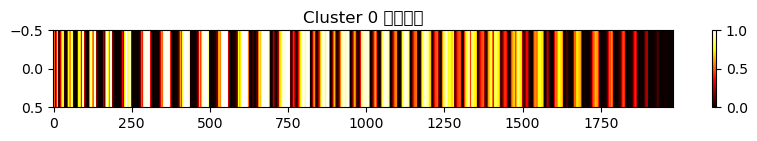

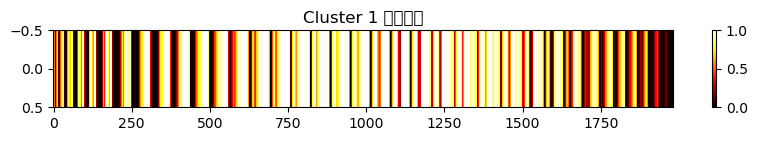

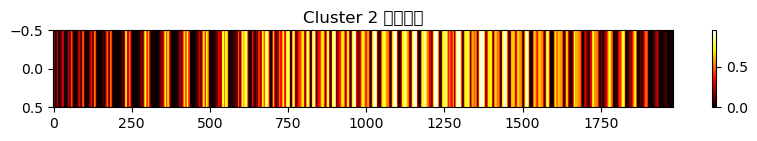

196111.0
196112.0
196113.0
196114.0
196124.0
196130.0
196131.0
196132.0
196133.0
196134.0
196135.0
196136.0
196137.0
196138.0
196139.0
196140.0
196141.0
196142.0
196170.0
196171.0
196172.0
196173.0
196174.0
196175.0
196176.0
196177.0
196184.0
196235.0
196236.0
196255.0
196256.0
196257.0
196258.0
196259.0
196260.0
196261.0
196262.0
196263.0
196264.0
196265.0
196266.0
196267.0
196268.0
196269.0
196270.0
196271.0
196272.0
196273.0
196274.0
196280.0
196281.0
196282.0
196326.0
196327.0
196328.0
196329.0
196330.0
196331.0
196332.0
196339.0
196340.0
196341.0
196342.0
196343.0
196344.0
196348.0
196349.0
196353.0
196354.0
196355.0
196356.0
196357.0
196358.0
196359.0
196360.0
196361.0
196362.0
196363.0
196364.0
196365.0
196368.0
196369.0
196370.0
196371.0
196372.0
196373.0
196374.0
196375.0
196376.0
196377.0
196378.0
196379.0
196380.0
196381.0
196382.0
196383.0
196387.0
196430.0
196431.0
196450.0
196451.0
196452.0
196453.0
196461.0
196462.0
196466.0
196467.0
196468.0
196469.0
196471.0
196472.0
1

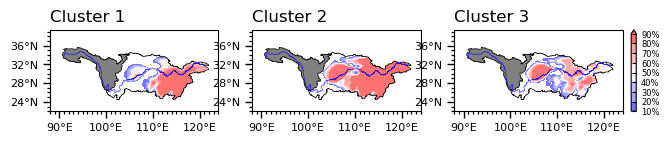

In [280]:
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

K_s = 3
K = K_Mean(EHD20_.to_numpy(), K_s)
# 绘制三种聚类的平均分布图
fig = plt.figure(figsize=(10, 5))
time = [[] for i in range(K_s)]
for cluster in range(K_s):
    extent_CN = [88, 124, 22, 38]  # 中国大陆经度范围，纬度范围
    ax = fig.add_subplot(1, K_s + 1, cluster + 1, projection=ccrs.PlateCarree())
    ax.set_title(f"Cluster {cluster + 1}", loc='left')
    ax.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(
        r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(),
                      ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='blue', linewidth=0.2)
    ax.set_extent(extent_CN)
    # 刻度线设置
    proj = ccrs.PlateCarree()   # 投影方式
    xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
    yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
    ax.set_xticks(xticks1, crs=proj)
    ax.set_yticks(yticks1, crs=proj)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    xmajorLocator = MultipleLocator(10)#先定义xmajorLocator，再进行调用
    ax.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
    xminorLocator = MultipleLocator(1)
    ax.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度
    ymajorLocator = MultipleLocator(4)
    ax.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
    yminorLocator = MultipleLocator(1)
    ax.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
    # 调整刻度值字体大小
    ax.tick_params(axis='both', labelsize=8, colors='black')
    # 最大刻度、最小刻度的刻度线长短，粗细设置
    ax.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
    ax.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    KM = []
    for i in K[cluster]['indices']:
        KM.append(EHD20.iloc[i].to_numpy())
        time[cluster].append(str(int(EHD20_time[i-1])))
        print(EHD20_time[i-1])
    KM = np.array(KM).mean(axis=0)
    con = ax.contourf(CN051_2['lon'], CN051_2['lat'], KM.reshape(163, 283),
                      cmap=cmaps.GMT_polar[4:-4], transform=ccrs.PlateCarree(),
                      levels=np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9]), extend='max')

    print(f'---{cluster}---' * 10)
# 色标
ax_colorbar = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cb1 = plt.colorbar(con, cax=ax_colorbar, orientation='vertical')
cb1.locator = ticker.FixedLocator(np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9]))
cb1.set_ticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
cb1.ax.tick_params(length=3, labelsize=6, direction='in')  # length为刻度线的长度
plt.show()

In [283]:
Time_type = np.zeros((62, K_s))
for i in range(K_s):
    for iyear in time[i]:
        index = eval(iyear[:4]) - 1961  # 年份索引
        Time_type[index, i] += 1
Time_type = xr.Dataset({'K': (['year', 'type'], Time_type)},
                       coords={'year': [i for i in range(1961, 2023)], 'type': [i for i in range(1, K_s + 1)]})
try:
    Time_type.to_netcdf(fr'D:\PyFile\p2\data\Time_type_AverFiltAll{T_th}%_{S_q}_{K_s}.nc')
except:
    pass

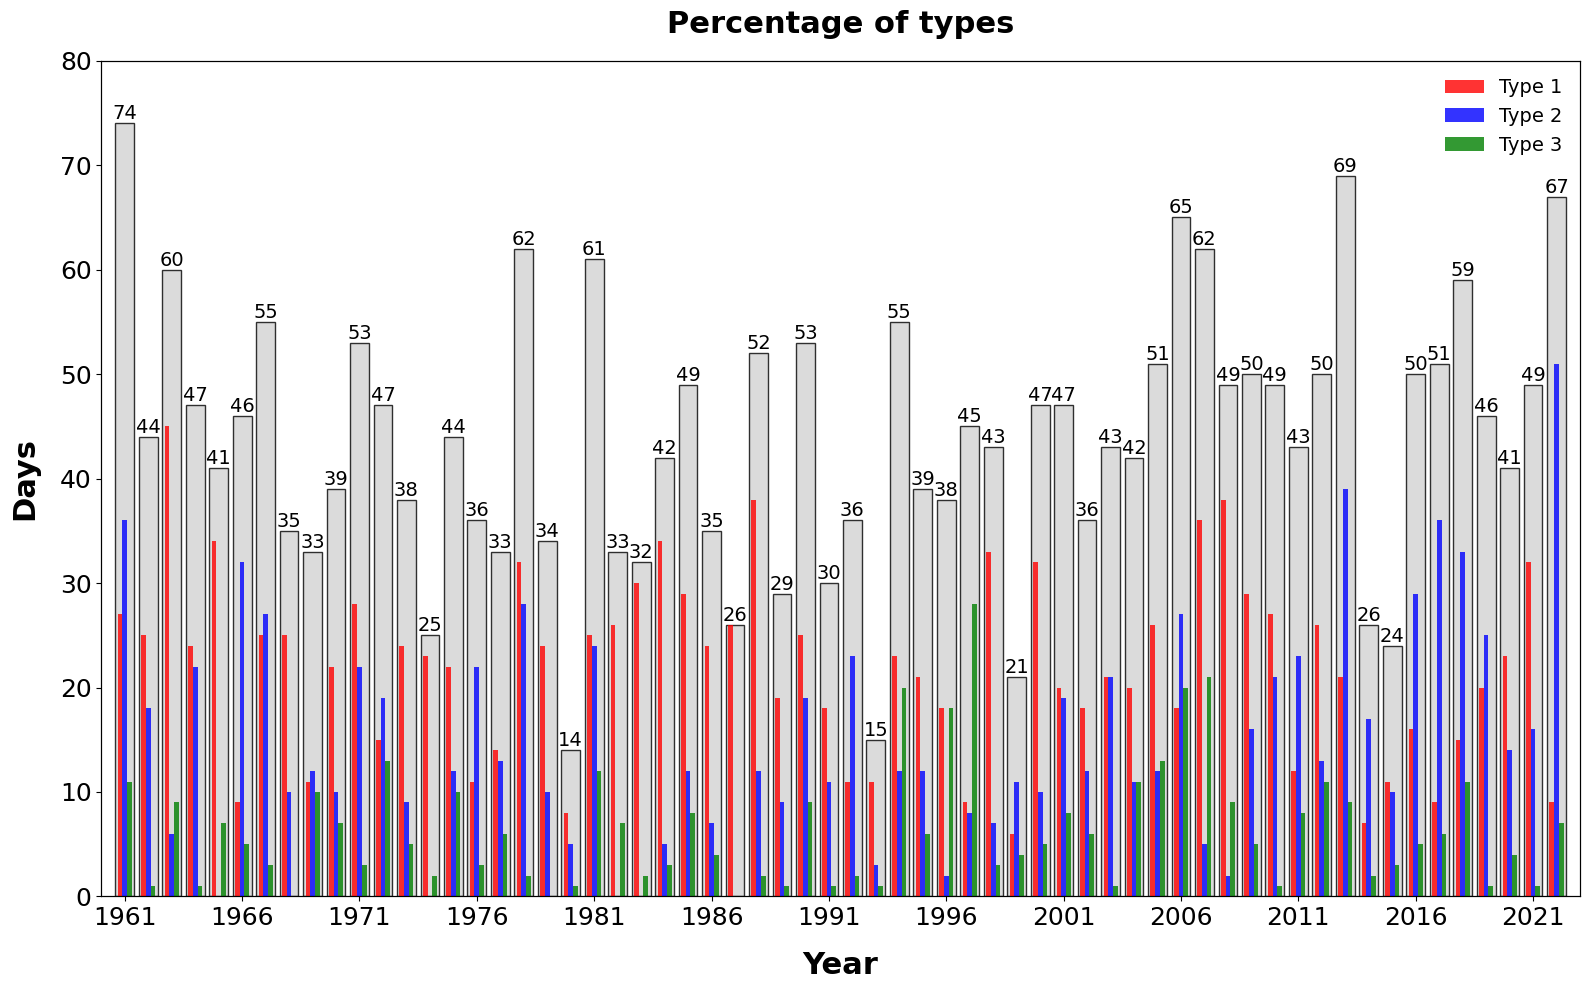

In [288]:
# 加载数据集
data = Time_type

# 将数据集转换为 Pandas DataFrame 以便更容易操作
df = data.to_dataframe().reset_index()

# 按年和类型分组，并对 K 值求和
grouped_data = df.groupby(['year', 'type'])['K'].sum().unstack()

# 计算每年的总和和每种类型的占比
total_by_year = grouped_data.sum(axis=1)  # 每年的总和
proportion_by_type = grouped_data.div(total_by_year, axis=0)  # 每种类型的占比

# 定义折线图的颜色
contrasting_colors = ['red', 'blue', 'green']

# 开始绘制图表
fig, ax1 = plt.subplots(figsize=(16, 10))

# 绘制柱状图（单色表示每年的总天数）
bars = ax1.bar(grouped_data.index, total_by_year, color='lightgray', alpha=0.8, edgecolor='black', label='')
ax1.set_title('Percentage of types', fontsize=22, weight='bold', pad=20)  # 设置标题
ax1.set_xlim(1960, 2023)
ax1.set_xlabel('Year', fontsize=22, labelpad=15, weight='bold')  # 设置 x 轴标签
ax1.set_ylim(0, 80)
ax1.set_ylabel('Days', fontsize=22, labelpad=15, weight='bold')  # 设置 y 轴标签
ax1.tick_params(axis='x', rotation=0, labelsize=18)  # 设置 x 轴刻度标签旋转和大小
ax1.tick_params(axis='y', labelsize=18)  # 设置 y 轴刻度标签大小
ax1.set_xticks(range(1961, 1961+len(total_by_year), 5))  # 设置 x 轴的刻度点间隔为 5 年
ax1.set_xticklabels(total_by_year.index[::5])  # 设置 x 轴的刻度标签

# 在柱状图顶部添加数值标注
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=14)

# 添加网格线，使图表更加美观
#ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 颜色
colors = ['red', 'blue', 'green']

# 绘制并排柱状图（不同颜色表示每种类型的占比）
x = np.arange(len(grouped_data.index))  # the label locations
width = 0.2  # the width of the bars
ax = ax1.twinx()  # 创建第二个 y 轴

# 绘制每种类型的柱状图
for i, col in enumerate(grouped_data.columns):
    ax.bar(
        1961 - width  + x + i * width,  # Offset each type's bars
        grouped_data[col],
        width=width,
        label=f'Type {col}',
        color=colors[i],
        edgecolor='none',
        alpha=0.8
    )

ax.set_ylim(0, 80)
ax.yaxis.set_visible(False)  # ax隐藏y轴标签
ax.legend(fontsize=14, loc='upper right', edgecolor='none')

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 自动调整布局，避免标签重叠
plt.tight_layout()

# 显示图表
plt.show()